# Classification

## Objectives

*   Fit and evaluate a deep learning classification model to predict if a treatment will be successful or not.


## Inputs

* outputs/datasets/collection/FertilityTreatmentData.csv.gz
* Instructions from the notebooks 02 and 04 on which variables to use for data cleaning and feature engineering.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

## Change working directory

Change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/jupyter_notebooks'

To make the parent of the current directory the new current directory:
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("A new current directory has been set")

A new current directory has been set


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor'

---

## Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd

# Open dataset
df = pd.read_csv("outputs/datasets/collection/FertilityTreatmentData.csv.gz")
        
print(df.shape)
df.head(3)

(169616, 61)


/var/folders/ps/q2jlnsf17tx866fp04k_jkg00000gn/T/ipykernel_26471/3215408494.py:5: DtypeWarning: Columns (4,38,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("outputs/datasets/collection/FertilityTreatmentData.csv.gz")


,Patient age at treatment,Total number of previous IVF cycles,Total number of previous DI cycles,Total number of previous pregnancies - IVF and DI,Total number of previous live births - IVF or DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,...,Heart three weeks gestation,Heart three birth outcome,Heart three birth weight,Heart three sex,Heart three birth congenital abnormalities,Heart three delivery date,Patient ethnicity,Partner ethnicity,Partner Type,Partner age
0,45-50,3,0,0.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Black,Other,Male,NaN
1,18-34,0,0,NaN,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,White,Other,NaN,NaN
2,999,0,0,NaN,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Other,Other,NaN,NaN


---

## Step 2: ML Pipeline with all data

#### ML pipeline for Data Cleaning and Feature Engineering

Custom Transformers:

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin


class FilterIVFTreatments(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.query(
            "`Main reason for producing embroys storing eggs` == 'Treatment - IVF'"
        )

class DropErroneousEntries(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(
            X[(X["Live birth occurrence"] == 1) & (X["Embryos transferred"] == 0)].index
        )

class ConvertToNumeric(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            # Replace '>3' with 4
            X[col] = X[col].replace(">3", 4)
            # Convert to numeric
            X[col] = pd.to_numeric(X[col])
        return X


class ConvertToIntegers(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            # Replace '>3' with 4 and convert to int
            X[col] = X[col].replace(">3", 4).astype(float).astype(int)
        return X


class FillSpermSource(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Sperm source"] = X.apply(self._fill_sperm_source, axis=1)
        return X

    def _fill_sperm_source(self, row):
        if pd.isna(row["Sperm source"]):
            if not pd.isna(row["Sperm donor age at registration"]):
                return "Donor"
            else:
                return "Partner"
        return row["Sperm source"]


# Convert float values to integers and handle NaN values
class ConvertToIntAndReplace999(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Fill NaN with -1 and convert to int
        X["Date of embryo transfer"] = (
            X["Date of embryo transfer"].fillna(-1).astype(int)
        )
        # Replace 999 with 0
        X["Date of embryo transfer"] = X["Date of embryo transfer"].replace(999, 0)
        return X


# Replace missing values based on the "Embryos transferred" column
class ReplaceMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Date of embryo transfer"] = X.apply(self._replace_missing, axis=1)
        return X

    def _replace_missing(self, row):
        value = row["Date of embryo transfer"]
        if value == -1 and row["Embryos transferred"] == 0:
            return "NT"
        elif value == -1:
            return "Missing"
        return value


# Append strings based on the "Fresh cycle" and "Frozen cycle" values
class AppendCycleType(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Date of embryo transfer"] = X.apply(self._append_cycle_type, axis=1)
        return X

    def _append_cycle_type(self, row):
        value = row["Date of embryo transfer"]
        if value not in ["NT", "Missing"]:
            if row["Fresh cycle"] == 1:
                value = f"{value} - fresh"
            elif row["Frozen cycle"] == 1:
                value = f"{value} - frozen"
            else:
                value = f"{value} - Mixed fresh/frozen"
        return value


class MicroInjectedEmbryos(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Embryos transferred from eggs micro-injected imputation
        missing_micro_injected = X[
            "Embryos transferred from eggs micro-injected"
        ].isna()
        ICSI = X["Specific treatment type"].str.contains("ICSI")
        # Only replace missing values
        X.loc[
            missing_micro_injected & ICSI,
            "Embryos transferred from eggs micro-injected",
        ] = X.loc[missing_micro_injected & ICSI, "Embryos transferred"]
        X.loc[
            missing_micro_injected & ~ICSI,
            "Embryos transferred from eggs micro-injected",
        ] = 0

        return X


class DonorAgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Mapping from donor age ranges to patient/partner age ranges
        self.egg_age_map = {
            'Between 21 and 25': '18-34',
            'Between 26 and 30': '18-34',
            'Between 31 and 35': '18-34',
            '>35': '38-39',
            '<= 20': '18-34'
        }
        self.sperm_age_map = {
            'Between 21 and 25': '18-34',
            'Between 26 and 30': '18-34',
            'Between 31 and 35': '18-34',
            'Between 36 and 40': '38-39',
            'Between 41 and 45': '43-44',
            '>45': '45-50',
            '<= 20': '18-34'
        }
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Egg donor age imputation
        X['Egg donor age at registration'] = X['Egg donor age at registration'].map(self.egg_age_map)
        missing_egg_age = (X['Egg donor age at registration'].isna()) & (X['Egg source'] == 'Patient')
        X.loc[missing_egg_age, 'Egg donor age at registration'] = X.loc[missing_egg_age, 'Patient age at treatment']
        X.rename(columns={'Egg donor age at registration': 'Patient/Egg provider age'}, inplace=True)
        
        # Sperm donor age imputation
        X['Sperm donor age at registration'] = X['Sperm donor age at registration'].map(self.sperm_age_map)
        missing_sperm_age = (X['Sperm donor age at registration'].isna()) & (X['Sperm source'] == 'Partner')
        X.loc[missing_sperm_age, 'Sperm donor age at registration'] = X.loc[missing_sperm_age, 'Partner age']
        X.rename(columns={'Sperm donor age at registration': 'Partner/Sperm provider age'}, inplace=True)

        # Drop the "Partner age" column
        X.drop(columns=['Partner age'], inplace=True)
        
        # Ensure no duplicate columns
        if X.columns.duplicated().any():
            raise ValueError("Duplicate column names found after transformation")
        
        return X


class FloatToIntTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.float_vars = None

    def fit(self, X, y=None):
        # Identify float columns
        self.float_vars = X.select_dtypes(include="float").columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.float_vars:
            X[var] = X[var].astype(int)
        return X


class EFlaggingTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X["Embryos transferred"] = X.apply(self.append_e, axis=1)
        return X

    def append_e(self, row):
        if (
            row["Embryos transferred"] == 1
            and row["Elective single embryo transfer"] == 1
        ):
            return "1e"
        else:
            return row["Embryos transferred"]


class TypeOfCycleAppender(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_update):
        self.columns_to_update = columns_to_update

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Ensure columns have the correct data type to avoid issues
        for column in self.columns_to_update:
            X[column] = X[column].astype(str)

        # Apply transformation for frozen cycle
        for column in self.columns_to_update:
            X.loc[(X["Frozen cycle"] == 1) & (X[column] == "0"), column] = (
                "0 - frozen cycle"
            )

        # Apply transformation for fresh cycle
        X["Total embryos thawed"] = X["Total embryos thawed"].astype(str)
        X.loc[
            (X["Fresh cycle"] == 1) & (X["Total embryos thawed"] == "0"),
            "Total embryos thawed",
        ] = "0 - fresh cycle"

        return X


class DropRowsWith999(BaseEstimator, TransformerMixin):
    """
    Custom transformer to drop rows with the value "999" in any column.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # Drop rows where any column has the value "999"
        X_filtered = X[(X != "999").all(axis=1)]
        
        return X_filtered


#### Pipeline

In [6]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures, SmartCorrelatedSelection
from feature_engine.imputation import ArbitraryNumberImputer, DropMissingData
from feature_engine.encoding import OneHotEncoder

# Columns to drop
columns_to_drop = [
    "Total number of previous DI cycles",
    "Main reason for producing embroys storing eggs",
    "Type of treatment - IVF or DI",
    "Donated embryo",
    "Eggs thawed (0/1)",
    "Year of treatment",
    "Number of live births",
    "Embryos stored for use by patient",
    "Fresh eggs stored (0/1)",
    "Heart three birth congenital abnormalities",
    "Heart two birth congenital abnormalities",
    "Heart three delivery date",
    "Heart three sex",
    "Heart three birth weight",
    "Heart three weeks gestation",
    "Heart three birth outcome",
    "Heart one birth congenital abnormalities",
    "Heart two birth weight",
    "Heart two delivery date",
    "Heart two sex",
    "Heart two weeks gestation",
    "Heart two birth outcome",
    "Heart one birth weight",
    "Heart one weeks gestation",
    "Heart one delivery date",
    "Heart one sex",
    "Heart one birth outcome",
    "Number of foetal sacs with fetal pulsation",
    "Early outcome",
    "Partner Type",
]

# Columns to be updated with the type of cycle
columns_to_update = [
    "Fresh eggs collected",
    "Total eggs mixed",
    "Total embryos created",
]


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline(
        [
            # Data Cleaning Steps
            ("filter_ivf", FilterIVFTreatments()),
            ("drop_erroneous", DropErroneousEntries()),
            ("drop_columns", DropFeatures(features_to_drop=columns_to_drop)),
            (
                "convert_to_numeric",
                ConvertToNumeric(
                    columns=[
                        "Total number of previous pregnancies - IVF and DI",
                        "Total number of previous live births - IVF or DI",
                    ]
                ),
            ),
            (
                "zeros_imputer",
                ArbitraryNumberImputer(
                    arbitrary_number=0,
                    variables=[
                        "Total number of previous pregnancies - IVF and DI",
                        "Total number of previous live births - IVF or DI",
                    ],
                ),
            ),
            (
                "convert_to_int",
                ConvertToIntegers(
                    columns=[
                        "Total number of previous pregnancies - IVF and DI",
                        "Total number of previous live births - IVF or DI",
                    ]
                ),
            ),
            ("fill_sperm_source", FillSpermSource()),
            ("dot_to_int_999", ConvertToIntAndReplace999()),
            ("replace_missing_values", ReplaceMissingValues()),
            ("append_cycle_type", AppendCycleType()),
            ("micro_injected", MicroInjectedEmbryos()),
            ("donor_age", DonorAgeImputer()),
            ("float_to_int", FloatToIntTransformer()),
            ("e_flagging", EFlaggingTransformer()),
            ("type_of_cycle", TypeOfCycleAppender(columns_to_update=columns_to_update)),
            ("drop_999", DropRowsWith999()),
            ("drop_missing_data", DropMissingData()),

            # Feature Engineering Steps
            (
                "one_hot_encoding",
                OneHotEncoder(
                    drop_last=True,
                    variables=[
                        "Patient age at treatment",
                        "Total number of previous IVF cycles",
                        "Patient/Egg provider age",
                        "Partner/Sperm provider age",
                        "Specific treatment type",
                        "Egg source",
                        "Sperm source",
                        "Patient ethnicity",
                        "Partner ethnicity",
                        "Fresh eggs collected",
                        "Total eggs mixed",
                        "Total embryos created",
                        "Embryos transferred",
                        "Total embryos thawed",
                        "Date of embryo transfer",
                    ],
                ),
            ),
            
            (
                "smart_correlation",
                SmartCorrelatedSelection(
                    method="spearman", threshold=0.9
                ),
            ),
        ]
    )

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('filter_ivf', FilterIVFTreatments()),
                ('drop_erroneous', DropErroneousEntries()),
                ('drop_columns',
                 DropFeatures(features_to_drop=['Total number of previous DI '
                                                'cycles',
                                                'Main reason for producing '
                                                'embroys storing eggs',
                                                'Type of treatment - IVF or DI',
                                                'Donated embryo',
                                                'Eggs thawed (0/1)',
                                                'Year of treatment',
                                                'Number of live births',
                                                'Embryos stored for use by '
                                                'patien...
                                          'Total number of previous IVF cycles',
                                          'Patient/Egg provider age',
                                          'Partner/Sperm provider age',
                                          'Specific treatment type',
                                          'Egg source', 'Sperm source',
                                          'Patient ethnicity',
                                          'Partner ethnicity',
                                          'Fresh eggs collected',
                                          'Total eggs mixed',
                                          'Total embryos created',
                                          'Embryos transferred',
                                          'Total embryos thawed',
                                          'Date of embryo transfer'])),
                ('smart_correlation',
                 SmartCorrelatedSelection(method='spearman', threshold=0.9))])

---

## Step 3: Sequential model (Deep Learning)

### Split Train and Test Set

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    # Do not drop the target column here because it is needed for the pipeline
    df,
    df["Live birth occurrence"],
    test_size=0.2,
    random_state=0,
)


Apply the data cleaning and feature engineering pipeline

In [8]:
X_train.head(3)

,Patient age at treatment,Total number of previous IVF cycles,Total number of previous DI cycles,Total number of previous pregnancies - IVF and DI,Total number of previous live births - IVF or DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,...,Heart three weeks gestation,Heart three birth outcome,Heart three birth weight,Heart three sex,Heart three birth congenital abnormalities,Heart three delivery date,Patient ethnicity,Partner ethnicity,Partner Type,Partner age
141611,40-42,1,0,NaN,0.0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,White,White,Male,45-50
98484,40-42,4,0,NaN,0.0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,White,White,Male,38-39
158125,38-39,0,0,NaN,NaN,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,White,White,Male,45-50


In [9]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)

In [10]:
X_train.head(3)

,Total number of previous pregnancies - IVF and DI,Total number of previous live births - IVF or DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,PGT-M treatment,PGT-A treatment,Embryos transferred from eggs micro-injected,...,Date of embryo transfer_2 - frozen,Date of embryo transfer_5 - Mixed fresh/frozen,Date of embryo transfer_7 - fresh,Date of embryo transfer_0 - fresh,Date of embryo transfer_1 - fresh,Date of embryo transfer_5 - frozen,Date of embryo transfer_6 - frozen,Date of embryo transfer_2 - Mixed fresh/frozen,Date of embryo transfer_7 - frozen,Date of embryo transfer_6 - Mixed fresh/frozen
141611,0,0,1,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
158125,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34201,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Realign y_train indices with the transformed X_train to keep only the rows present on the dataset after the cleaning step

In [11]:
y_train = y_train.loc[X_train.index]

Apply the pipeline to the test set and realign indices on y_test

In [12]:
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
y_test = y_test.loc[X_test.index]


Drop the target column from the processed X_train and X_test

In [13]:
X_train = X_train.drop(["Live birth occurrence"], axis=1)
X_test = X_test.drop(["Live birth occurrence"], axis=1)

In [14]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(108583, 96) (108583,) (27112, 96) (27112,)


Check Train Set Target distribution

0    77485
1    31098
Name: Live birth occurrence, dtype: int64


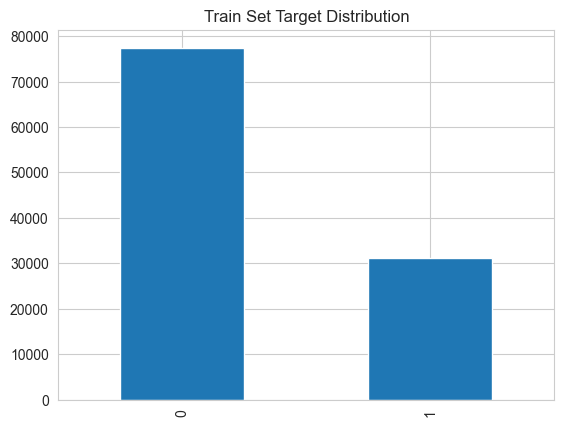

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

print(y_train.value_counts())

sns.set_style("whitegrid")
y_train.value_counts().plot(kind="bar", title="Train Set Target Distribution")
plt.show()

## Handle Target Imbalance

### Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [16]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(154970, 96) (154970,) (27112, 96) (27112,)


Check Train Set Target distribution after resampling

1    77485
0    77485
Name: Live birth occurrence, dtype: int64


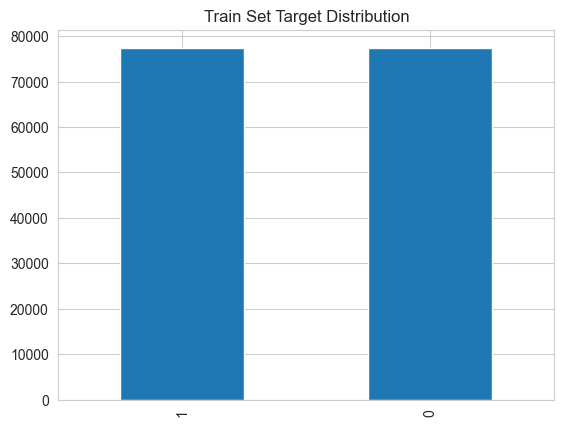

In [17]:
import matplotlib.pyplot as plt

print(y_train.value_counts())

y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Further split Train set to validation and Train set

In [18]:
from sklearn.model_selection import train_test_split

# Create new training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0
)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(123976, 96) (30994, 96) (123976,) (30994,)


Scale Features

In [19]:
from sklearn.preprocessing import StandardScaler


def pipeline_pre_processing():
    pipeline_base = Pipeline([("feat_scaling", StandardScaler())])

    return pipeline_base

In [20]:
pipeline = pipeline_pre_processing()
X_train = pipeline.fit_transform(X_train)
X_val= pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

X_train[:2,]

array([[-0.44705538, -0.39907208, -0.31268822, -0.34939463, -0.70625569,
         1.54282313, -0.22484447, -0.09848798, -0.11332571,  2.05481062,
        -0.36586567, -0.39266839, -0.54537217,  1.13962563, -0.14572555,
         1.69122931, -0.76874292, -0.29381483, -0.17777267, -0.41577777,
        -0.15030673, -0.15663898, -0.29891977, -0.48145878, -0.13794304,
        -0.36417716,  1.34979013, -0.37945425, -0.24931259, -0.07594775,
         1.26560271, -0.69272556, -0.63229663, -0.01631721, -0.04263997,
         0.25637241,  0.31634279,  0.67810712, -0.10663948, -0.32882479,
        -0.14198695,  0.69062271, -0.44480032, -0.31550896, -0.13611015,
        -0.14180948, -0.49196841, -0.39309244, -0.24196547, -0.40201736,
        -0.25847425, -0.08484094, -0.15134163, -0.04933354, -0.02769233,
        -0.53343448, -0.45715553, -0.38209254, -0.16054099, -0.13069206,
        -0.23041132, -0.06973652, -0.0216345 , -0.03989419, -0.50593936,
        -0.63818725,  1.29992665, -0.2129264 , -0.2

Define early stopping callback

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    patience=20,
    restore_best_weights=True,  
    monitor='val_accuracy',
    verbose=1, 
    mode='max' 
)

Define deep learning model

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

def create_dl_model(input_shape):
    model = tf.keras.Sequential([
        # First hidden layer with 64 neurons and a dropout rate of 0.7
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.7),
        # Second hidden layer with 32 neurons and a dropout rate of 0.7
        Dense(32, activation='relu'),
        Dropout(0.7),
        # Output layer for binary classification
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


Get input shape from X_train

In [23]:
input_shape = X_train.shape[1:]


Train deep learning model

In [24]:
dl_model = create_dl_model(input_shape)
dl_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv-311/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-29 21:54:36.046991: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-08-29 21:54:36.047018: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-29 21:54:36.047028: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-29 21:54:36.047123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-29 21:54:36.047141: I tensorflow/core/common_runtime/pl

Epoch 1/100


2024-08-29 21:54:36.506441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3875/3875 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.5758 - loss: 0.7463 - val_accuracy: 0.6725 - val_loss: 0.5851
Epoch 2/100
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.6700 - loss: 0.5960 - val_accuracy: 0.6986 - val_loss: 0.5473
Epoch 3/100
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.6920 - loss: 0.5636 - val_accuracy: 0.7140 - val_loss: 0.5282
Epoch 4/100
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.7031 - loss: 0.5512 - val_accuracy: 0.7145 - val_loss: 0.5223
Epoch 5/100
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.7019 - loss: 0.5480 - val_accuracy: 0.7163 - val_loss: 0.5168
Epoch 6/100
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.7053 - loss: 0.5420 - val_accuracy: 0.7180 - val_loss: 0.5163
Epoch 7/100
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.7098 - loss: 0.5374 - val_accuracy: 0.7192 - val_loss: 0.5189
Epoch 8/100
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.7119 - loss: 0.536

 ### Model Evaluation

In [25]:
history = pd.DataFrame(dl_model.history.history)
history.head()

,accuracy,loss,val_accuracy,val_loss
0,0.620644,0.658896,0.672517,0.585141
1,0.677050,0.586963,0.698587,0.547340
2,0.694594,0.560512,0.714041,0.528211
3,0.703047,0.549546,0.714493,0.522334
4,0.705499,0.546484,0.716300,0.516786


Plot loss and accuracy

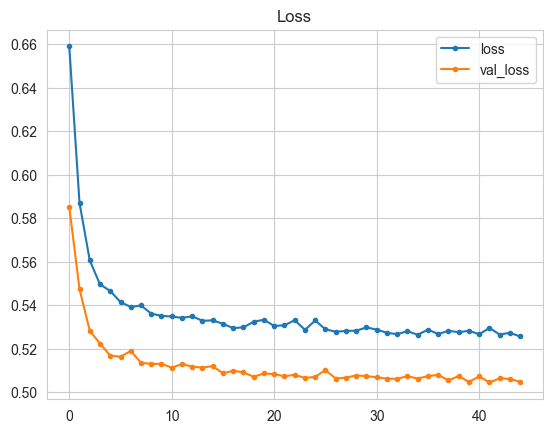

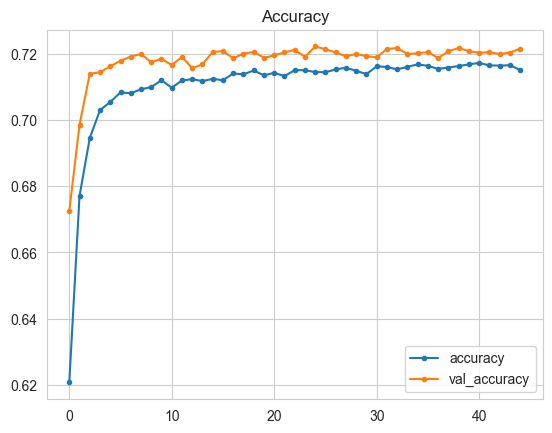

In [26]:
sns.set_style("whitegrid")
history[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.show()

print("\n")
history[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.show()

Evaluate the model performance on the test set

In [27]:
dl_model.evaluate(X_test,y_test)

848/848 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6546 - loss: 0.5781


[0.5805314183235168, 0.6532531976699829]

Confusion matrix

In [28]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):
    prediction = pipeline.predict(X).reshape(-1)
    prediction = np.where(prediction < 0.5, 0, 1)

    print("---  Confusion Matrix  ---")
    print(
        pd.DataFrame(
            confusion_matrix(y_true=prediction, y_pred=y),
            columns=[["Actual " + sub for sub in label_map]],
            index=[["Prediction " + sub for sub in label_map]],
        )
    )
    print("\n")

    print("---  Classification Report  ---")
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(
    X_train, y_train, X_test, y_test, X_val, y_val, pipeline, label_map
):

    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Validation Set #### \n")
    confusion_matrix_and_report(X_val, y_val, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [29]:
clf_performance(X_train, y_train,
                X_test,y_test,
                X_val, y_val,
                dl_model,
                label_map= ['No Success', 'Success']
                )

#### Train Set #### 

3875/3875 ━━━━━━━━━━━━━━━━━━━━ 3s 693us/step
---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success             47181          18866
Prediction Success                14942          42987


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.71      0.76      0.74     62123
     Success       0.74      0.69      0.72     61853

    accuracy                           0.73    123976
   macro avg       0.73      0.73      0.73    123976
weighted avg       0.73      0.73      0.73    123976
 

#### Validation Set #### 

969/969 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step
---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success             11595           4840
Prediction Success                 3767          10792


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.71    

---